In [2]:
import time
from ML4transients.data_access import DatasetLoader
from ML4transients.training import PytorchDataset

print("Loading dataset...")
t0 = time.time()
dataset = DatasetLoader('/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_norm')
print(f"Dataset loaded in {time.time() - t0:.2f} seconds")

2025-08-28 21:04:12.364969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 21:04:14.214783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756407854.905722 2191791 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756407855.079506 2191791 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756407856.035539 2191791 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Loading dataset...
Dataset loaded in 0.20 seconds


# Cutouts


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

first_visit = dataset.visits[0]
print(f"Loading cutouts from visit {first_visit}")

cutout_loader = dataset.cutouts[first_visit]
feature_loader = dataset.features[first_visit]
sample_ids = cutout_loader.ids[:6]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, dia_id in enumerate(sample_ids):
    cutout = cutout_loader.get_by_id(dia_id)
    features = feature_loader.get_by_id(dia_id)
    is_injection = features['is_injection'].iloc[0] if not features.empty else False
    
    im = axes[i].imshow(cutout, cmap='RdYlGn', origin='lower')
    axes[i].set_title(f'ID: {dia_id}\nInjection: {is_injection}')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"Cutout shape: {cutout.shape}")
print(f"Value range: [{cutout.min():.3f}, {cutout.max():.3f}]")

# LC visualization

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

first_visit = dataset.visits[0]
sample_dia_source_id = dataset.cutouts[first_visit].ids[10]

print(f"Performance comparison for diaSourceId: {sample_dia_source_id}")
print("=" * 60)

# Method 1: Lightcurve only
print("\nMethod 1: Lightcurve columns only")
start_time = time.time()
data_lc_only = dataset.get_complete_lightcurve_data(sample_dia_source_id, load_cutouts=False)
time_lc_only = time.time() - start_time

if data_lc_only:
    print(f"Success: {data_lc_only['num_sources']} sources, {len(data_lc_only['lightcurve'])} LC points")
    print(f"Time: {time_lc_only:.3f}s")
else:
    print("Failed")

print("-" * 60)

# Method 2: Lightcurve + cutouts
print("\nMethod 2: Lightcurve + cutouts")
start_time = time.time()
data_full = dataset.get_complete_lightcurve_data(sample_dia_source_id, load_cutouts=True)
time_full = time.time() - start_time

if data_full:
    print(f"Success: {data_full['num_sources']} sources, {len(data_full['cutouts'])} cutouts")
    print(f"Time: {time_full:.3f}s")
else:
    print("Failed")

print("=" * 60)

# Performance summary
if data_lc_only and data_full:
    speedup = time_full / time_lc_only
    print(f"\nSpeedup: {speedup:.1f}x faster (lightcurve-only)")
    print(f"Time saved: {time_full - time_lc_only:.3f}s")

In [ ]:
# Plot all cutouts
if data_full and data_full['cutouts']:
    cutouts = data_full['cutouts']
    lightcurve = data_full['lightcurve']
    
    # Sort by time if available
    if 'diaSourceId' in lightcurve.columns and 'midpointMjdTai' in lightcurve.columns:
        time_map = dict(zip(lightcurve['diaSourceId'], lightcurve['midpointMjdTai']))
        sorted_ids = sorted(cutouts.keys(), key=lambda x: time_map.get(x, 0))
    else:
        sorted_ids = list(cutouts.keys())
    
    n_cutouts = len(cutouts)
    cols = min(8, n_cutouts)
    rows = (n_cutouts + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    if n_cutouts == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, src_id in enumerate(sorted_ids):
        im = axes[i].imshow(cutouts[src_id], cmap='RdYlGn', origin='lower')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    
    for i in range(n_cutouts, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'Cutouts for object {data_full["object_id"]} ({n_cutouts} total)')
    plt.tight_layout()
    plt.show()
else:
    print("No cutouts available")

# Lc inference

In [ ]:
t1 = time.time()

dataset = DatasetLoader('/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_norm')

ensemble_df = dataset.lightcurves.inference_snn

print(f"Inference done in {time.time() - t1:.2f} seconds")

In [ ]:
dataset = DatasetLoader('/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_norm')
t2 = time.time()

high_conf = list(dataset.lightcurves.get_high_conf_sn_sources())
t3 = time.time()

dataset.lightcurves.save_high_conf_subset_dataset("/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_norm_high_conf_smallv2", prob_threshold = 0.9, std_threshold= 0.001)
print(f"Save high conf LC done in {time.time() - t3:.2f} seconds")


Found 4548 high-confidence diaObjectId candidates.
Total high-confidence diaSourceIds found: 382764
Found 51 high-confidence diaObjectId candidates.
Total high-confidence diaSourceIds found: 13520
Saving 13520 high-confidence SN sources to mini-dataset.
      Cutout batch load (12 IDs): 0.570s (open: 0.001s, ids: 0.000s, index: 0.000s, read: 0.569s, map: 0.000s)
Saved 12 cutouts to /sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_norm_high_conf_smallv2/cutouts/visit_54098.h5
      Cutout batch load (15 IDs): 0.621s (open: 0.001s, ids: 0.000s, index: 0.000s, read: 0.620s, map: 0.000s)
Saved 15 cutouts to /sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_norm_high_conf_smallv2/cutouts/visit_57922.h5
      Cutout batch load (17 IDs): 0.773s (open: 0.001s, ids: 0.001s, index: 0.000s, read: 0.771s, map: 0.000s)
Saved 17 cutouts to /sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_norm_high_conf_smallv2/cutouts/visit_105506.h5
      Cutout batch load (9 IDs): 0.24

NameError: name 't3' is not defined

Total: 3143693 objects
Non-SN: 1674004 (53.2%)
Supernova: 1469689 (46.8%)

Uncertainty Statistics:
Mean SN probability uncertainty: 0.077
High uncertainty objects (std > 0.1): 437780

High-confidence SN (mean prob > 0.7): 55246
High-confidence + Low uncertainty (std < 0.05): 4548

Top 5 candidates (by mean probability):
  1. diaObjectId 3.495848842002171e+18: 1.000 ± 0.000
  2. diaObjectId 3.4958972205137925e+18: 1.000 ± 0.000
  3. diaObjectId 3.495897220513792e+18: 1.000 ± 0.000
  4. diaObjectId 3.4959455990254167e+18: 1.000 ± 0.000
  5. diaObjectId 3.49600277363006e+18: 1.000 ± 0.000


/sps/lsst/users/rbonnetguerrini/ML4transients/src/ML4transients/data_access/data_loaders.py:1346: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/sps/lsst/users/rbonnetguerrini/conda_envs/envs/env_ML/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


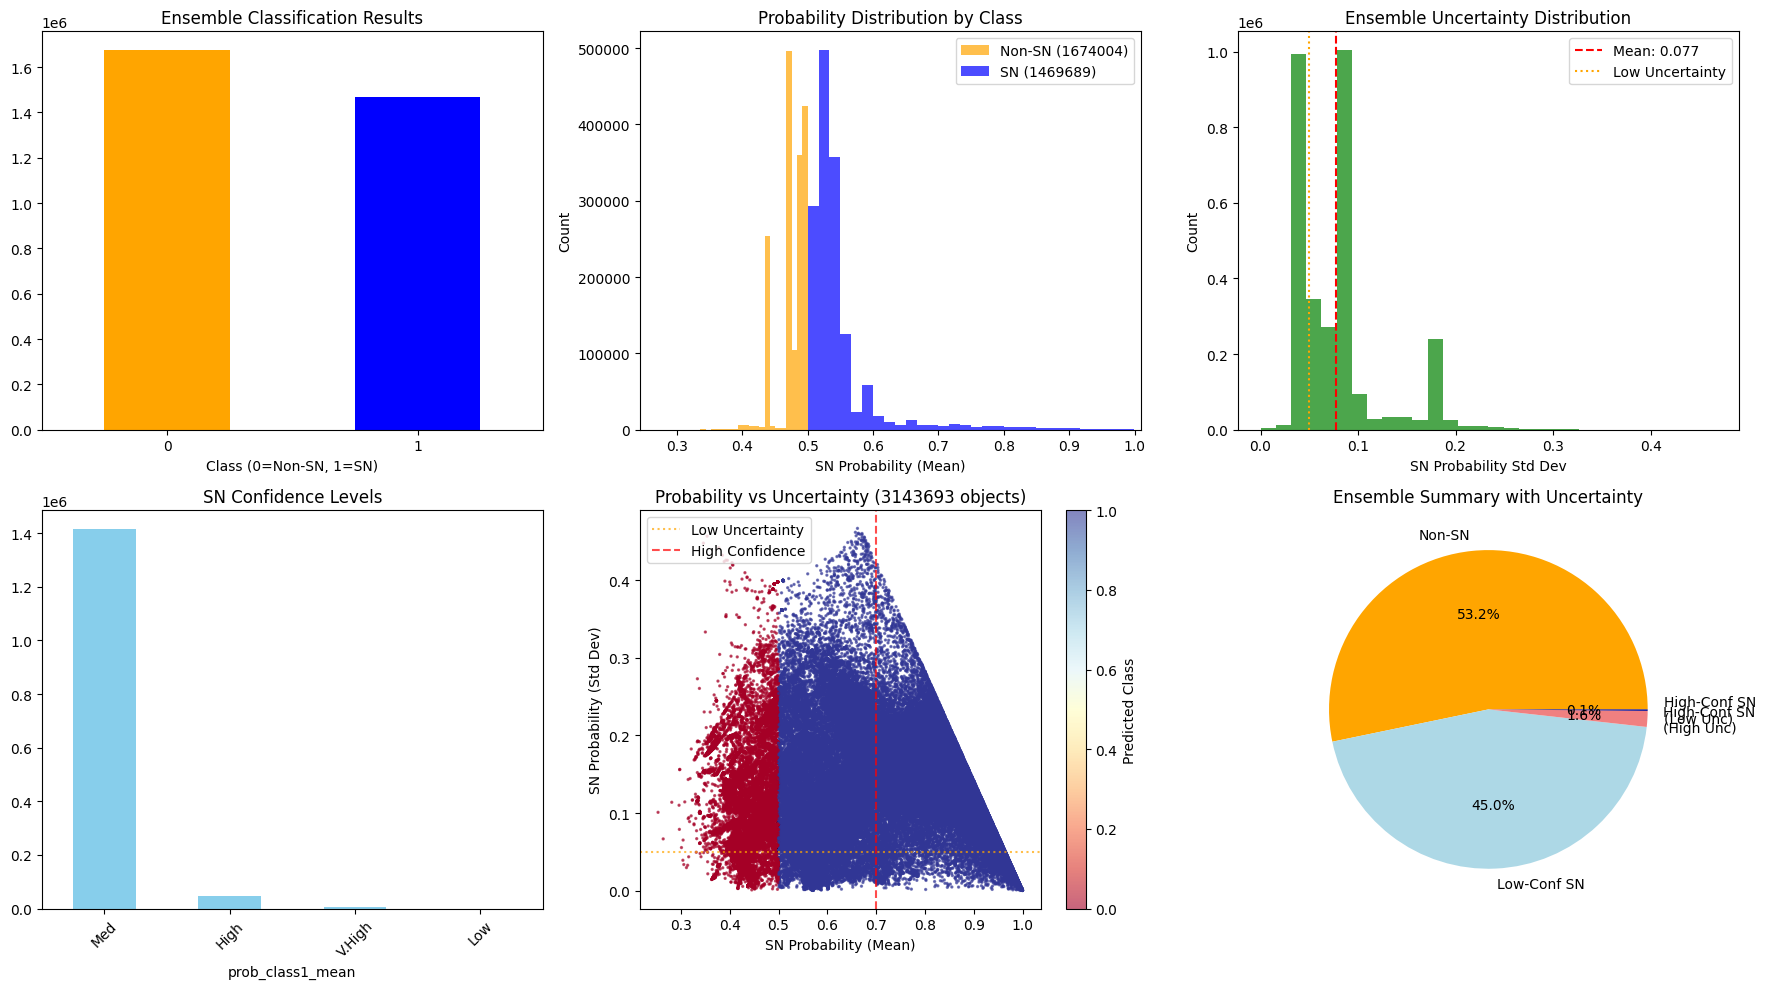


Ensemble Summary:
Total objects: 3143693
High-confidence SN candidates: 55246
High-conf + Low uncertainty: 4548
Mean uncertainty: 0.077
Objects with high uncertainty (>0.1): 437780


TypeError: 'DataFrame' object is not callable

In [4]:
dataset.lightcurves.inference_snn()

In [ ]:
dataset = DatasetLoader('/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_norm')
t2 = time.time()

high_conf = list(dataset.lightcurves.get_high_conf_sn_sources())
print(f"Get high conf LC done in {time.time() - t2:.2f} seconds")
t3 = time.time()

dataset.lightcurves.save_high_conf_subset_dataset("/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_norm_high_conf_smallv2", prob_threshold = 0.9, std_threshold= 0.001)
print(f"Save high conf LC done in {time.time() - t3:.2f} seconds")



Found 22218 high-confidence diaObjectId candidates.
Total high-confidence diaSourceIds found: 1425132
Get high conf LC done in 24.16 seconds
Save high conf LC done in 0.00 seconds


Found 510 high-confidence diaObjectId candidates.
Total high-confidence diaSourceIds found: 103667
Loaded lightcurve index with 3856539 objects


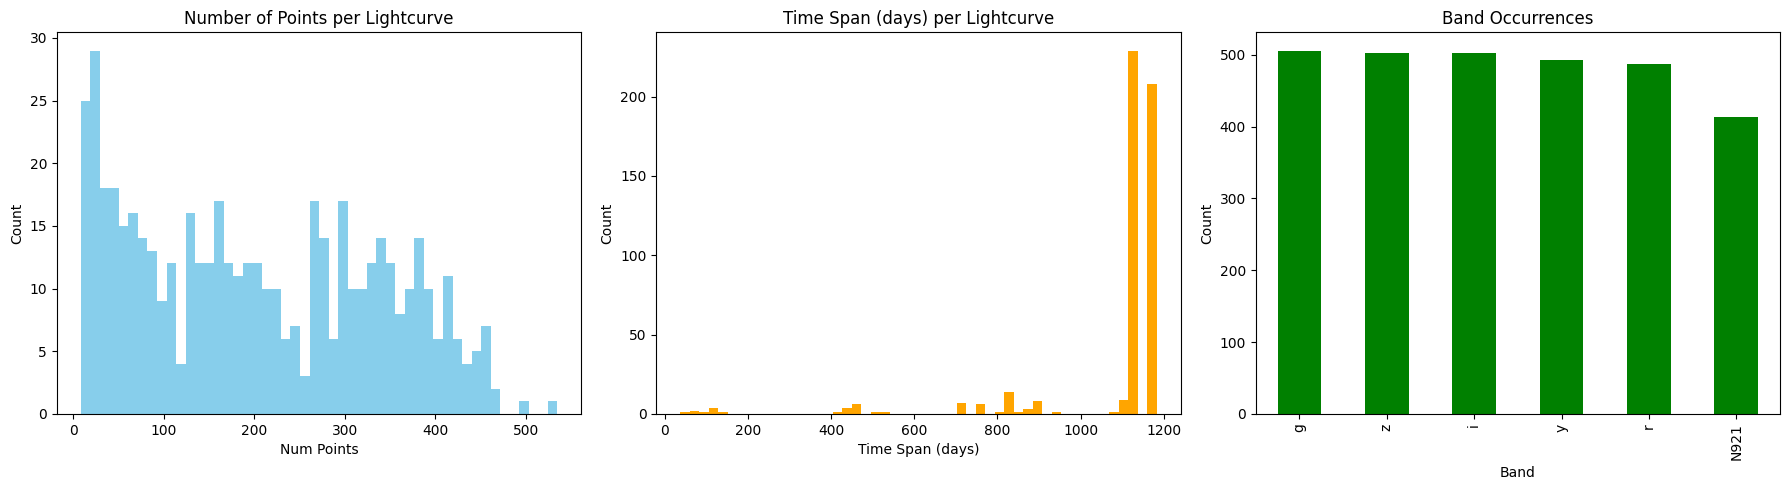

{'num_lightcurves': 510, 'num_points': {'mean': 203.2686274509804, 'median': 189.0, 'std': 134.3451524847671, 'min': 8, 'max': 535}, 'time_span_days': {'mean': 1089.5725389353224, 'median': 1130.8765510243102, 'std': 194.72920472216126, 'min': 36.96822344328393, 'max': 1182.9691027662047}, 'bands': {'unique': ['y', 'N921', 'z', 'i', 'g', 'r'], 'counts': {'g': 506, 'z': 503, 'i': 502, 'y': 493, 'r': 487, 'N921': 413}}}


In [5]:

high_conf = list(dataset.lightcurves.get_high_conf_sn_sources(prob_threshold=0.9, std_threshold=0.01))

diasource_index = dataset.lightcurves.diasource_index
# This will get the unique diaObjectIds corresponding to your high-confidence sources
high_conf_obj_ids = list(set(diasource_index.loc[
    diasource_index.index.isin(high_conf), 'diaObjectId'
]))

stats_dict = dataset.lightcurves.summarize_multiple_lightcurves(high_conf_obj_ids)
print(stats_dict)



Found 4255 high-confidence diaObjectId candidates.
Total high-confidence diaSourceIds found: 544102


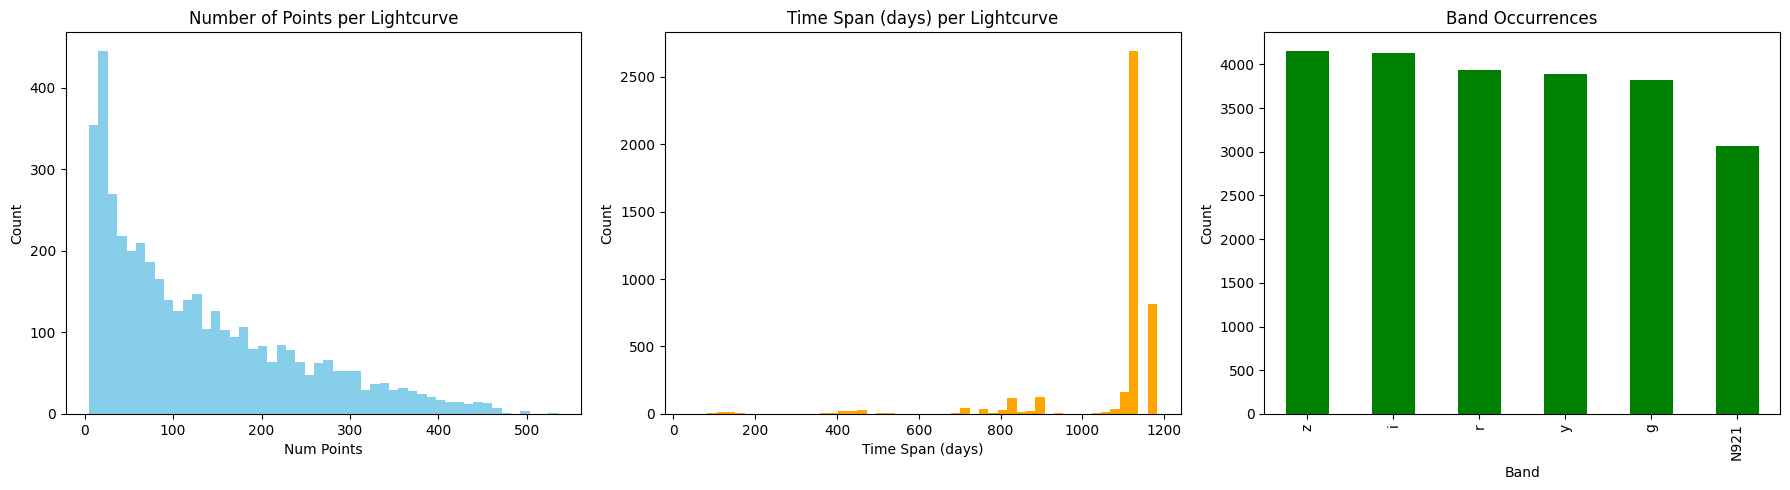

{'num_lightcurves': 4255, 'num_points': {'mean': 127.87356051703878, 'median': 95.0, 'std': 108.85717847553322, 'min': 5, 'max': 535}, 'time_span_days': {'mean': 1085.1059298150249, 'median': 1127.966980121535, 'std': 162.1657644842438, 'min': 36.96822344328393, 'max': 1182.9691027662047}, 'bands': {'unique': ['g', 'z', 'i', 'N921', 'y', 'r'], 'counts': {'z': 4160, 'i': 4134, 'r': 3938, 'y': 3892, 'g': 3823, 'N921': 3070}}}


In [ ]:

high_conf = list(dataset.lightcurves.get_high_conf_sn_sources(prob_threshold=0.9, std_threshold=0.01))

diasource_index = dataset.lightcurves.diasource_index
# This will get the unique diaObjectIds corresponding to your high-confidence sources
high_conf_obj_ids = list(set(diasource_index.loc[
    diasource_index.index.isin(high_conf), 'diaObjectId'
]))

stats_dict = dataset.lightcurves.summarize_multiple_lightcurves(high_conf_obj_ids)
print(stats_dict)

